In [6]:
import numpy as np
import numpy.random as npr
import datetime as dt
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
npr.seed(100)
np.set_printoptions(precision=4)
import math
import dx

# Valuation - Options
* all assets drift at the riskless short-rate - otherwise arbitrage
* because of this - the value of an option is tied to the single parameter of its volatility
* The payoff of a European option is ${h(S_{T} \equiv max(S_{T} - K, 0)}$
* A stochastic pricer for this risk-neutral expectation is ${C_{0} = e^{-rT} E_{0}^{Q}(h(S_{T}) = e^{-rT} \int_{0}^{\infty} h(s) q(s) ds}$
* Intuitively, the area under the 0-bounded curve of the security times a volatility process discounted to be risk-neutral
* Risk-neutral Monte Carlo estimator is ${\tilde{C_{0}} = e^{-rT} \sum_{1}^{I} h(S_{T}^{i})}$ with ${h(S_{T}^{i})}$ here as a stochastic security process

In [21]:
T = 1

In [22]:
def generate_var_reduced_random(partitions, trials):
    sn = npr.standard_normal((partitions + 1, trials))
    return (sn - sn.mean()) / sn.std()

In [23]:
def european_monte_carlo_valuation(trials, partitions, time, S0, r, sigma, strike, option):
    dt = time / partitions
    S = np.zeros((partitions + 1, trials))
    # Add more here
    S[0] = S0
    random_mesh = generate_var_reduced_random(partitions, trials)
    for t in range(1, partitions+1):
        S[t] = S[T-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * random_mesh[t]) # Run stochastic process
        
    if option =='call':
        hT = np.maximum(S[-1] - strike, 0)
    if option == 'put':
        hT = np.maximum(strike - S[-1], 0)
    C0 = math.exp(-r * T) * np.mean(hT) # Risk neutral mean of trials
    return S, hT, C0
    

In [24]:
euro_security_process, euro_trials, euro_price_mean = european_monte_carlo_valuation(10000, 50, 1, 100, r=0.05, sigma=0.1,
                                                         strike=120, option='put')

"\nSome fun distribution stuff here - we only get the right side of the distribution since we're 0 bounded.\nIncreasing volatility monotonically increases the number of 0s and also fattens the tail of the right side\n"

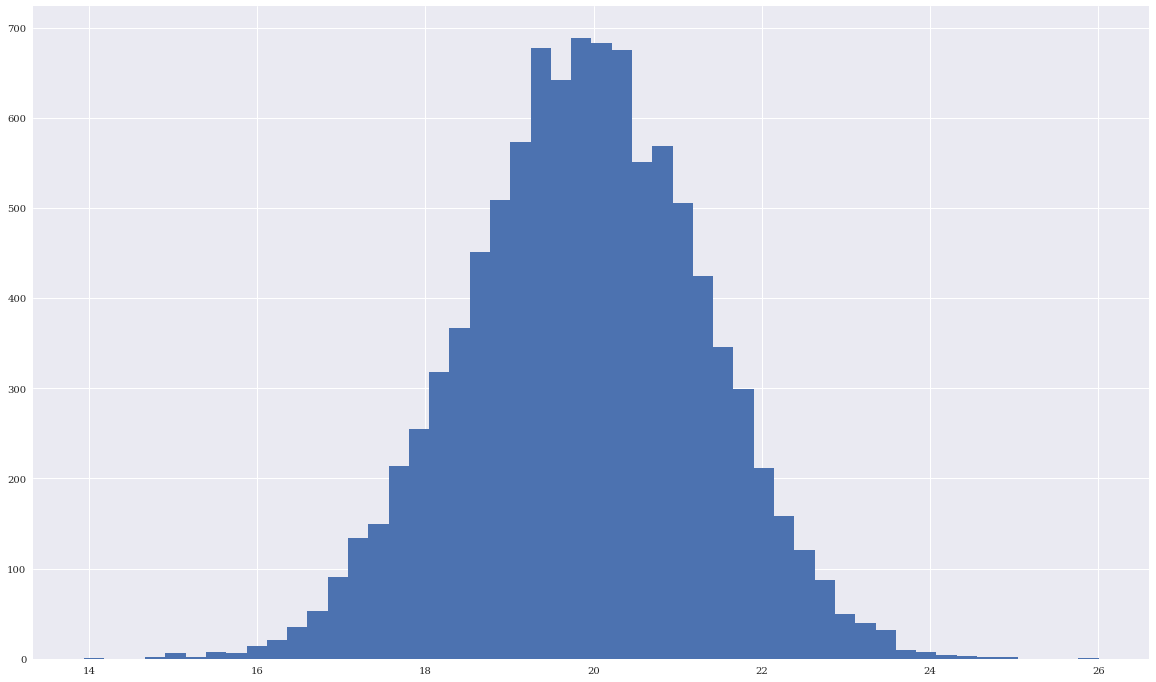

In [25]:
plt.figure(figsize=(20,12))
plt.hist(euro_trials, bins=50)
'''
Some fun distribution stuff here - we only get the right side of the distribution since we're 0 bounded.
Increasing volatility monotonically increases the number of 0s and also fattens the tail of the right side
''' 

Text(0.5, 1.0, 'Underlying Security Price')

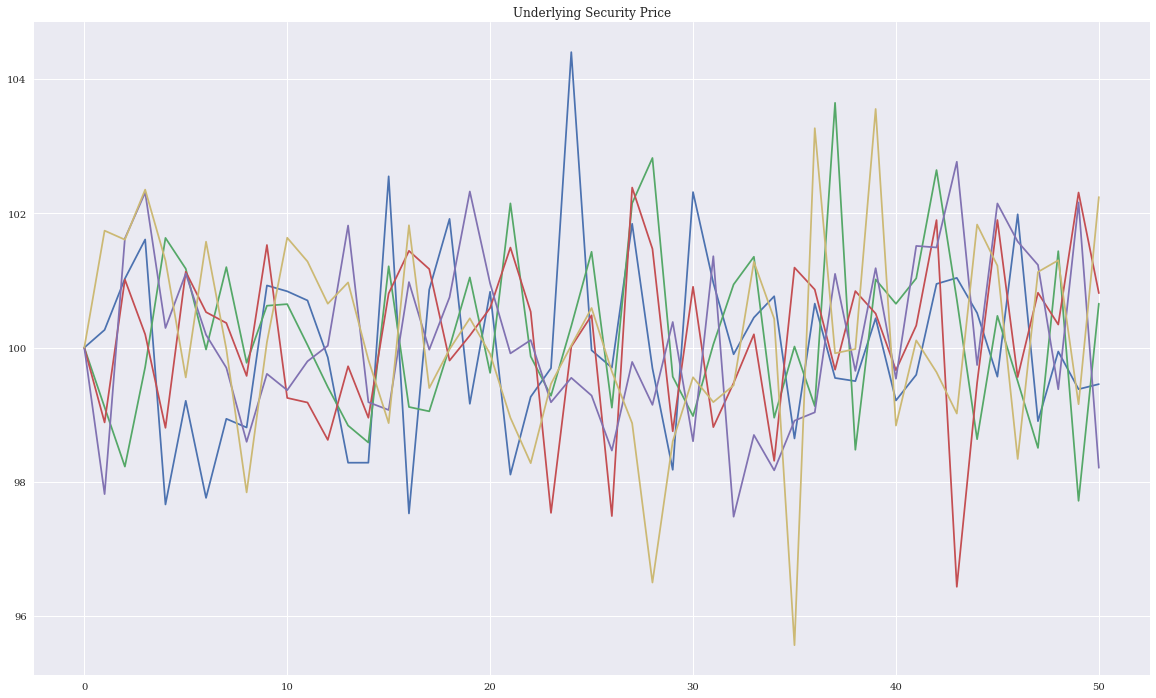

In [26]:
plt.figure(figsize=(20,12))
plt.plot(euro_security_process[:, :5])
plt.title('Underlying Security Price')

In [27]:
print(euro_price_mean)

18.91465657548319


In [28]:
def generate_european_price_surface(strikes, option):
    price_mean = []
    for K in strikes:
        process, option_trials, mean_strike = european_monte_carlo_valuation(10000, 50, 1.0, 100, r=0.05, sigma=0.1,
                                                         strike=K, option=option)
        price_mean.append(mean_strike)
    return price_mean

In [29]:
strike_list = np.arange(80., 140.1, 5.)
put_surface = generate_european_price_surface(strike_list, 'put')
put_surface = np.array(put_surface)
put_surface

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 6.7590e-05, 4.8590e-01,
       4.6673e+00, 9.4224e+00, 1.4167e+01, 1.8911e+01, 2.3700e+01,
       2.8439e+01, 3.3204e+01, 3.7950e+01])

Text(0.5, 0, 'Strike')

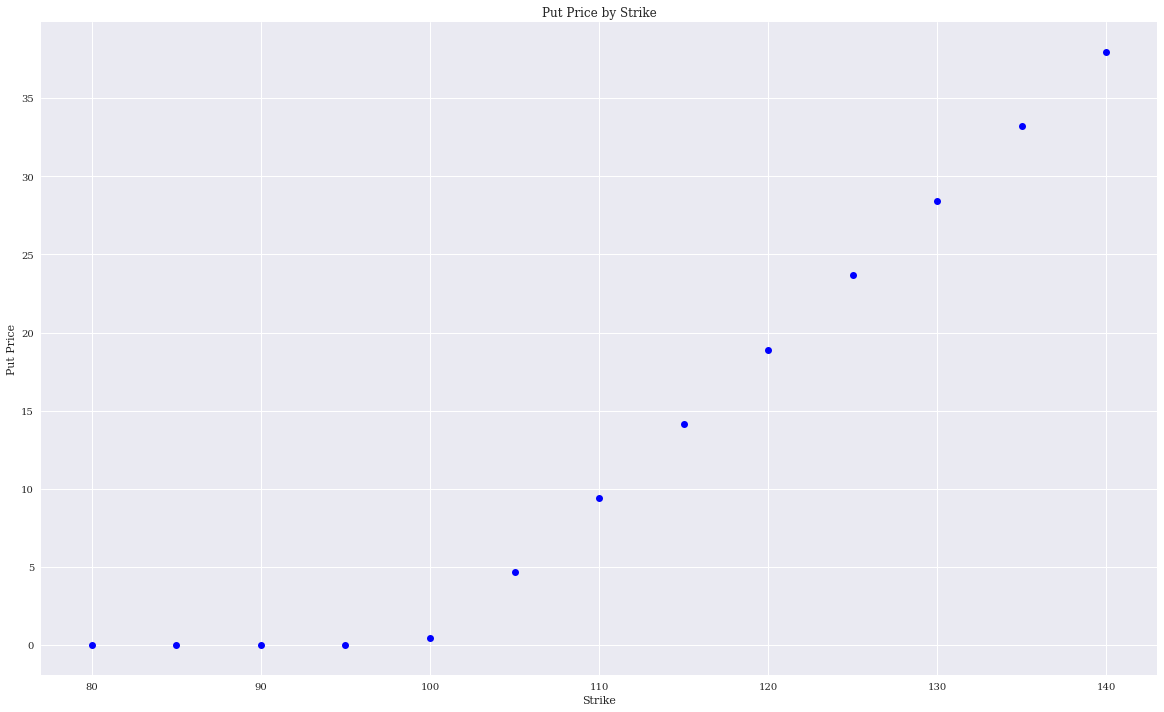

In [30]:
plt.figure(figsize=(20,12))
plt.plot(strike_list, put_surface, 'bo')
plt.title('Put Price by Strike')
plt.ylabel('Put Price')
plt.xlabel('Strike')

In [31]:
strike_list = np.arange(80., 140.1, 5.)
call_surface = generate_european_price_surface(strike_list, 'call')
call_surface = np.array(call_surface)
call_surface

array([1.9108e+01, 1.4369e+01, 9.5939e+00, 4.8538e+00, 5.9441e-01,
       9.7737e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00])

Text(0.5, 0, 'Strike')

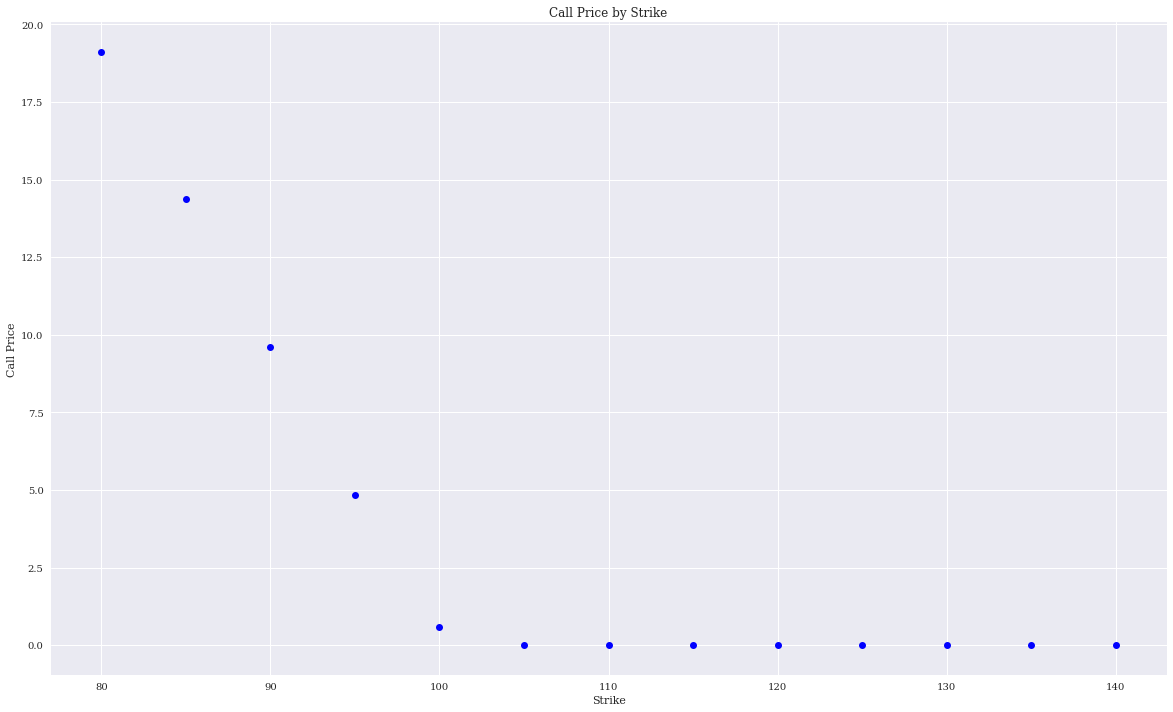

In [32]:
plt.figure(figsize=(20,12))
plt.plot(strike_list, call_surface, 'bo')
plt.title('Call Price by Strike')
plt.ylabel('Call Price')
plt.xlabel('Strike')

# DX Analytics Based Approach
* Assume a constant risk-free rate

In [10]:
r = dx.constant_short_rate('r', 0.06)
# Create a market environment
me = dx.market_environment('me', dt.datetime(2020, 1, 1))
me.add_constant('initial_value', 36.)
me.add_constant('volatility', 0.2)
me.add_constant('final_date', dt.datetime(2022, 12, 31))
me.add_constant('currency', 'EUR')
me.add_constant('frequency', 'W')
me.add_constant('paths', 50000)

In [11]:
me.add_curve('discount_curve', r)

In [12]:
gbm = dx.geometric_brownian_motion('gbm', me)

# DX European Call Option

In [14]:
# DX version of European Call Option for a Single Security
me.add_constant('maturity', dt.datetime(2021, 12, 13))
me.add_constant('strike', 40.)

In [16]:
call_eur = dx.valuation_mcs_european_single(name='call_eur',
                                           underlying=gbm,
                                           mar_env=me,
                                           payoff_func='np.maximum(maturity_value - strike, 0)')

In [21]:
call_eur.present_value()

4.722698

In [22]:
call_eur.delta()

0.6049

In [23]:
call_eur.vega()

21.9945

In [26]:
k_list = np.arange(12., 80.1, 2) # Calculate Greeks over the strike surface
pv = []
de = []
ga = []
ve = []
th = []
rh = []
for k in k_list:
    print('Calculating Strike ', str(k))
    call_eur.update(strike=k)
    pv.append(call_eur.present_value())
    de.append(call_eur.delta())
    ga.append(call_eur.gamma())
    ve.append(call_eur.vega())
    th.append(call_eur.theta())
    rh.append(call_eur.rho())

Calculating Strike  12.0
Calculating Strike  14.0
Calculating Strike  16.0
Calculating Strike  18.0
Calculating Strike  20.0
Calculating Strike  22.0
Calculating Strike  24.0
Calculating Strike  26.0
Calculating Strike  28.0
Calculating Strike  30.0
Calculating Strike  32.0
Calculating Strike  34.0
Calculating Strike  36.0
Calculating Strike  38.0
Calculating Strike  40.0
Calculating Strike  42.0
Calculating Strike  44.0
Calculating Strike  46.0
Calculating Strike  48.0
Calculating Strike  50.0
Calculating Strike  52.0
Calculating Strike  54.0
Calculating Strike  56.0
Calculating Strike  58.0
Calculating Strike  60.0
Calculating Strike  62.0
Calculating Strike  64.0
Calculating Strike  66.0
Calculating Strike  68.0
Calculating Strike  70.0
Calculating Strike  72.0
Calculating Strike  74.0
Calculating Strike  76.0
Calculating Strike  78.0
Calculating Strike  80.0


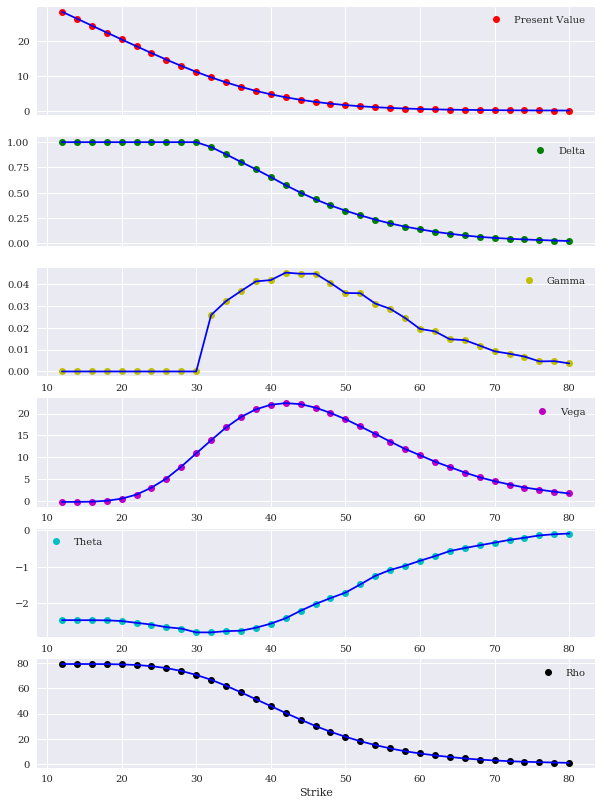

In [28]:
dx.plot_option_stats_full(k_list, pv, de, ga, ve, th, rh)

# DX European Put Option

In [66]:
me.add_constant('initial_value', 36.)
me.add_constant('maturity', dt.datetime(2022, 12, 31))
me.add_constant('model', 'gbm')

In [40]:
put_eur = dx.valuation_mcs_european_single(
name='put_eur',
underlying=gbm,
mar_env=me,
payoff_func='np.maximum(strike - maturity_value, 0)')

In [50]:
put_eur.delta()

-0.406

In [52]:
put_list = np.arange(26., 46.1, 2.)
pv = []
de = []
ga = []
ve = []
th = []
rh = []
for k in put_list:
    print('Calculating Strike ', str(k))
    put_eur.update(strike=k)
    pv.append(put_eur.present_value())
    de.append(put_eur.delta())
    ga.append(put_eur.gamma())
    ve.append(put_eur.vega())
    th.append(put_eur.theta())
    rh.append(put_eur.rho())

Calculating Strike  26.0
Calculating Strike  28.0
Calculating Strike  30.0
Calculating Strike  32.0
Calculating Strike  34.0
Calculating Strike  36.0
Calculating Strike  38.0
Calculating Strike  40.0
Calculating Strike  42.0
Calculating Strike  44.0
Calculating Strike  46.0


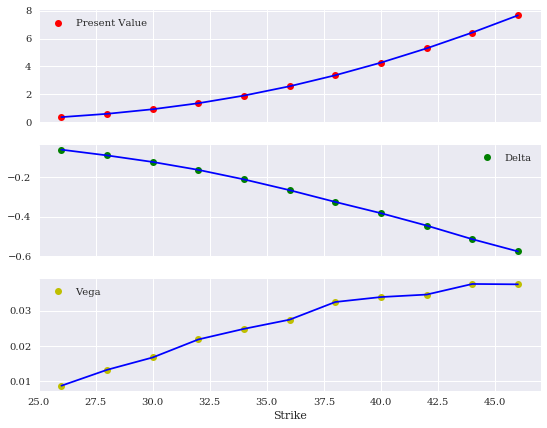

In [53]:
dx.plot_option_stats(put_list, pv, de, ga)

# DX Portfolio Valuation
* Valuing portfolio of multiple derivatives in one portfolio
* Two classes for this:
    1. `derivative_position` for the position size of a single derivative
    2. `derivative_portfolio` a portfolio of options
* `derivatives_portfolio` encompasses core portfolio valuation tasks

In [76]:
put = dx.derivatives_position(
                name='put',  # name of position
                quantity=1,  # number of instruments
                underlyings=['gbm'],  # relevant risk factors
                mar_env=me,  # market environment
                otype='European single',  # the option type
                payoff_func='np.maximum(40. - maturity_value, 0)')
                    # the payoff funtion

In [77]:
put.get_info()

NAME
put 

QUANTITY
1 

UNDERLYINGS
['gbm'] 

MARKET ENVIRONMENT

**Constants**
initial_value 36.0
volatility 0.2
final_date 2022-12-31 00:00:00
currency EUR
frequency M
paths 50000
maturity 2022-12-31 00:00:00
strike 40.0
starting_date 2020-01-01 00:00:00
model gbm

**Lists**
time_grid [datetime.datetime(2020, 1, 1, 0, 0) datetime.datetime(2020, 1, 31, 0, 0)
 datetime.datetime(2020, 2, 29, 0, 0) datetime.datetime(2020, 3, 31, 0, 0)
 datetime.datetime(2020, 4, 30, 0, 0) datetime.datetime(2020, 5, 31, 0, 0)
 datetime.datetime(2020, 6, 30, 0, 0) datetime.datetime(2020, 7, 31, 0, 0)
 datetime.datetime(2020, 8, 31, 0, 0) datetime.datetime(2020, 9, 30, 0, 0)
 datetime.datetime(2020, 10, 31, 0, 0)
 datetime.datetime(2020, 11, 30, 0, 0)
 datetime.datetime(2020, 12, 31, 0, 0)
 datetime.datetime(2021, 1, 31, 0, 0) datetime.datetime(2021, 2, 28, 0, 0)
 datetime.datetime(2021, 3, 31, 0, 0) datetime.datetime(2021, 4, 30, 0, 0)
 datetime.datetime(2021, 5, 31, 0, 0) datetime.datetime(2021, 6, 30, 0,

In [78]:
me_jump = dx.market_environment('me_jump', dt.datetime(2020, 1, 1))
me_jump.add_environment(me)
me_jump.add_constant('lambda', 0.6) # Poisson intensity
me_jump.add_constant('mu', -0.8) # Jump size
me_jump.add_constant('delta', 0.1) # Jump Variability
me_jump.add_constant('model', 'jd')

In [83]:
call_jump = dx.derivatives_position(
name='call_jump',
quantity=3,
underlyings=['jd'],
mar_env=me_jump,
otype='European single',
payoff_func='np.maximum(maturity_value - 36., 0)')

In [84]:
risk_factors = {'gbm': me, 'jd': me_jump}
positions = {'put': put, 'call_jump': call_jump}

In [85]:
val_env = dx.market_environment('general', dt.datetime(2020, 1, 1))
val_env.add_constant('frequency', 'M')
val_env.add_constant('paths', 50000)
val_env.add_constant('starting_date', val_env.pricing_date)
val_env.add_constant('final_date', val_env.pricing_date)
val_env.add_curve('discount_curve', r)

In [86]:
port = dx.derivatives_portfolio(
            name='portfolio',  # name 
            positions=positions,  # derivatives positions
            val_env=val_env,  # valuation environment
            risk_factors=risk_factors, # relevant risk factors
            correlations=False,  # correlation between risk factors
            fixed_seed=False,  # fixed seed for randon number generation
            parallel=False)  # parallel valuation of portfolio positions

In [87]:
stats = port.get_statistics()

Totals
 pos_value    62.3610
pos_delta     2.5382
pos_vega     58.7219
dtype: float64


In [88]:
stats

,position,name,quantity,otype,risk_facts,value,currency,pos_value,pos_delta,pos_vega
0,put,put,1,European single,[gbm],4.323,EUR,4.323,-0.4618,27.5939
1,call_jump,call_jump,3,European single,[jd],19.346,EUR,58.038,3.0000,31.1280


In [97]:
path_no = 0
paths1 = port.underlying_objects['jd'].get_instrument_values()[:, :10] # Pull some of the simulated paths

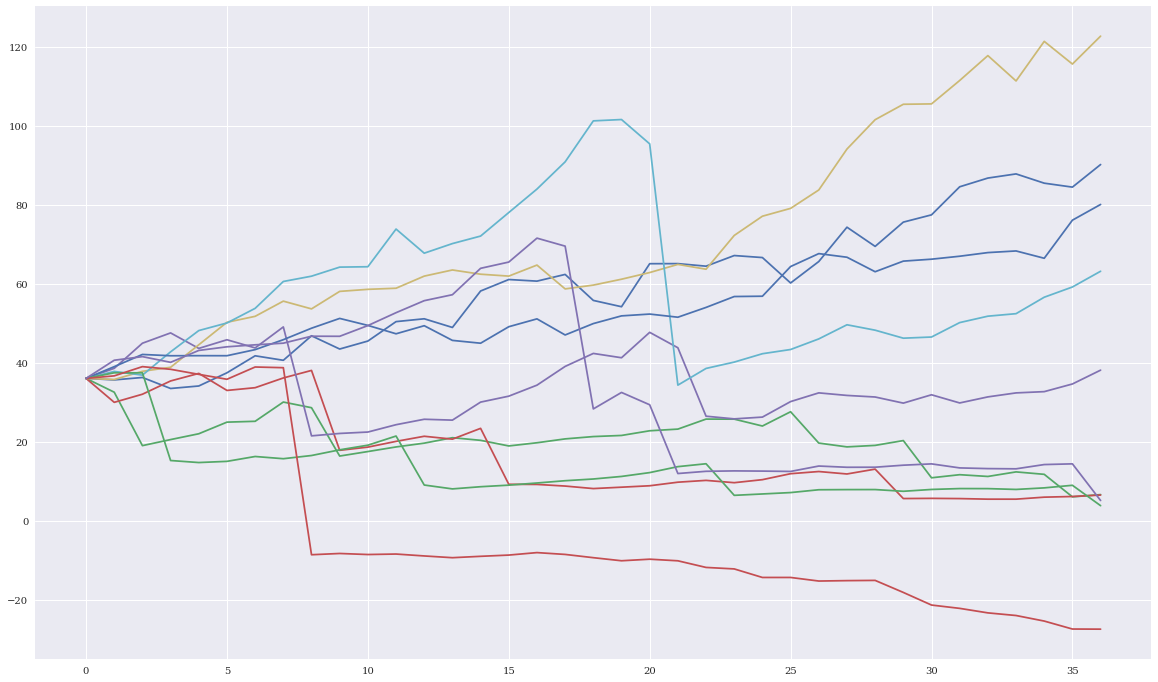

In [98]:
plt.figure(figsize=(20,12))
plt.plot(paths1)

In [99]:
# Now let's correlate the risk factors highly
correlations = [['gbm', 'jd', 0.9]]

In [102]:
port = dx.derivatives_portfolio(
            name='portfolio',
            positions=positions,
            val_env=val_env,
            risk_factors=risk_factors,
            correlations=correlations,
            fixed_seed=True,
            parallel=False)

In [104]:
stats_corr = port.get_statistics()
stats_corr

Totals
 pos_value    63.3290
pos_delta     2.5856
pos_vega     59.4111
dtype: float64


,position,name,quantity,otype,risk_facts,value,currency,pos_value,pos_delta,pos_vega
0,put,put,1,European single,[gbm],4.289,EUR,4.289,-0.4054,27.6093
1,call_jump,call_jump,3,European single,[jd],19.680,EUR,59.040,2.9910,31.8018


In [106]:
port.val_env.lists['cholesky_matrix'] # Cholesky used to transform risk outputs

array([[1.    , 0.    ],
       [0.9   , 0.4359]])

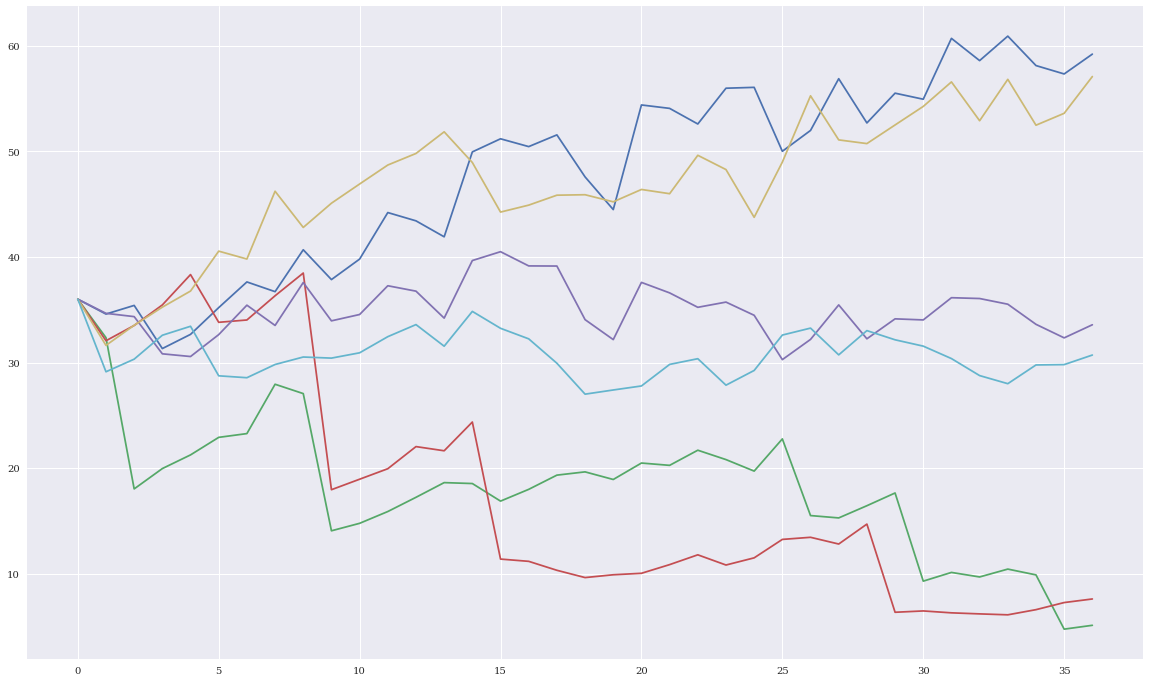

In [112]:
path_no = 0
paths1 = port.underlying_objects['jd'].get_instrument_values()[:, :3] # Pull some of the simulated paths
paths2 = port.underlying_objects['gbm'].get_instrument_values()[:, :3]
plt.figure(figsize=(20,12))
plt.plot(paths1)
plt.plot(paths2)